/home/jbris/miniconda3/envs/data_assim/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jbris/miniconda3/envs/data_assim/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jbris/miniconda3/envs/data_assim/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/jbris/miniconda3/envs/data_assim/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

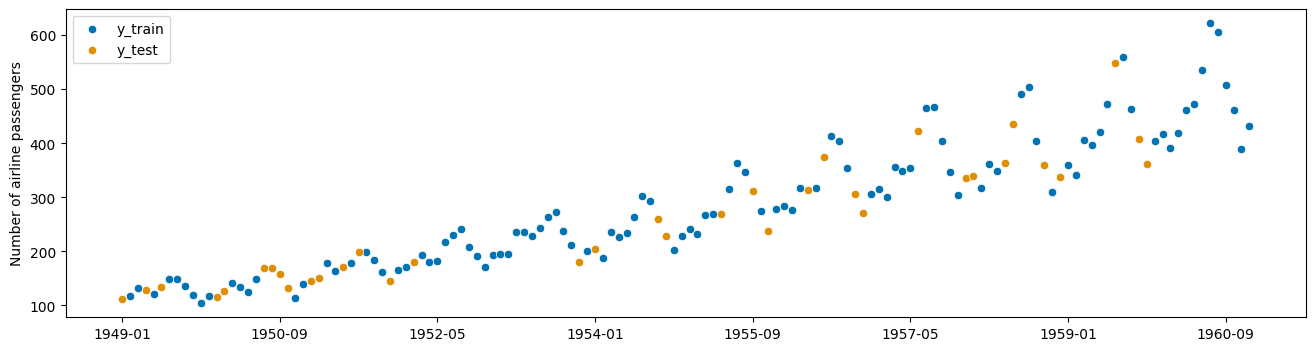

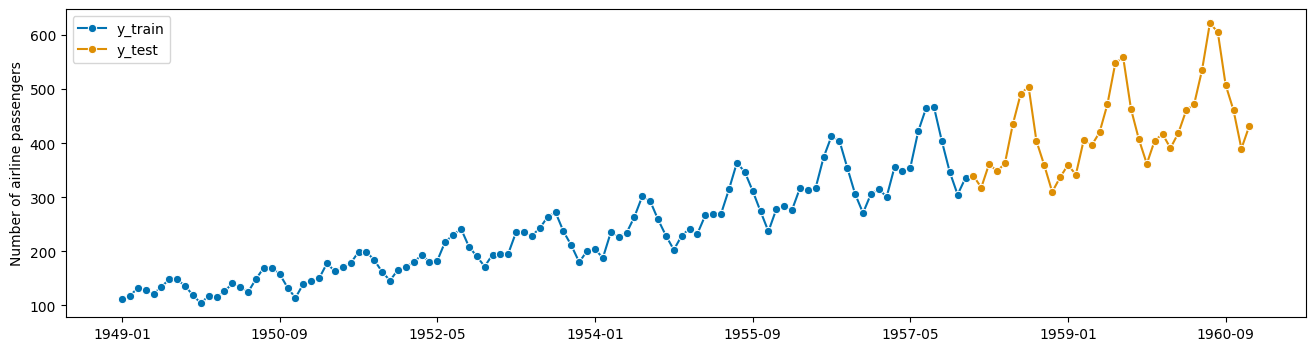

In [1]:
# general imports
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split
from sktime.utils.plotting import plot_series

y = load_airline()

y_train, y_test = train_test_split(y)
plot_series(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

y_train, y_test = temporal_train_test_split(y)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);


In [4]:
# suppose we want to predict 3 years ahead
fh = np.arange(1, 37)

# slightly modified code from the M4 competition


def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets.

    Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num) :]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
    #     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features]
    # (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for _ in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

# here we split the time index, rather than the actual values,
# to show how we split the windows
feature_window, target_window, _, _ = split_into_train_test(
    np.arange(len(y)), 10, len(fh)
)

x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

y_test = pd.Series(y_test, index=y.index[-len(fh) :])
y_pred = model.predict(x_test)

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(
    y_test, pd.Series(y_pred, index=y_test.index), symmetric=False
)

(98, 10) (98,)


0.11016755575864773

In [6]:
# slightly modified code from the M4 study
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)

    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction

    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=y_test.index)

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(
    y_test, pd.Series(y_pred_rec, index=y_test.index), symmetric=False
)

0.1582712526463812